In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#utils
from utils.num import Num

In [34]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [2]:
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

<BarContainer object of 10 artists>

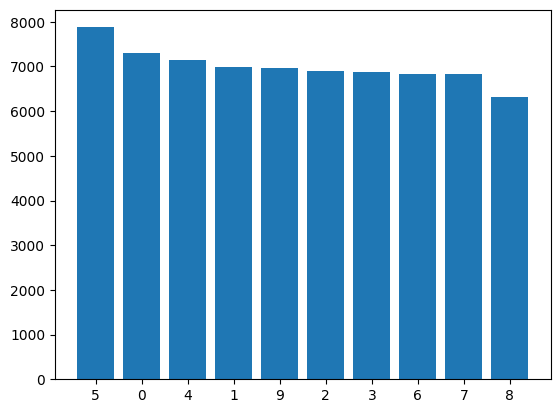

In [20]:
plt.bar(x = df['class'].unique(), height = df['class'].value_counts())

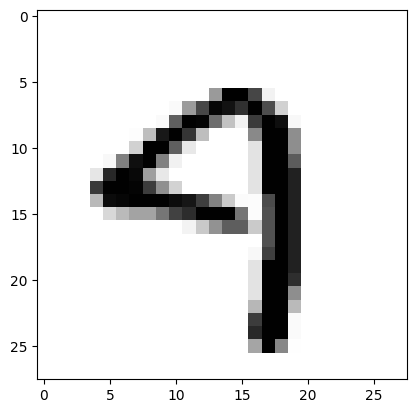

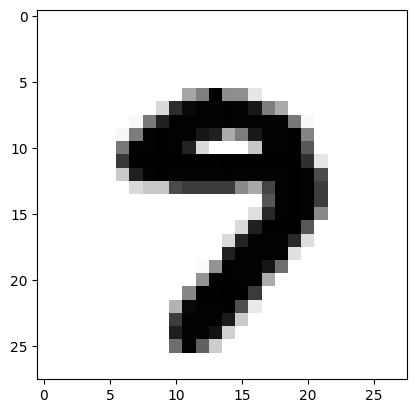

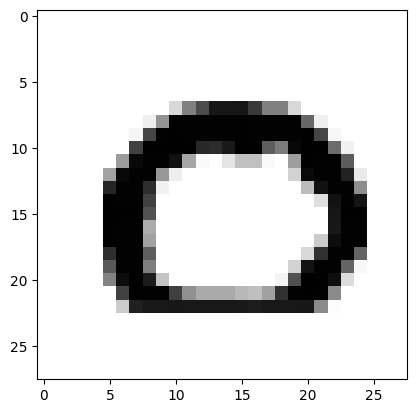

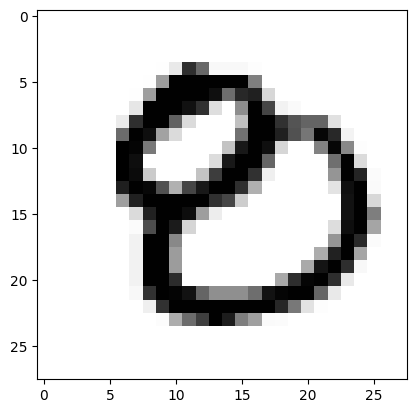

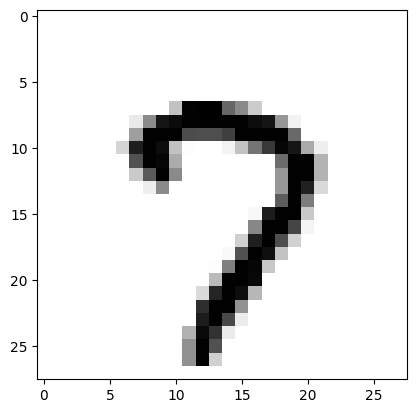

In [74]:
# Visualizando algumas instância do dataset

nums = df['class'].unique()

for i in np.random.randint(1000, size=5):
    p = np.reshape(np.array(df[df['class'] == np.random.choice(nums)].iloc[i][:-1]), (28,28)).astype('int')
    plt.imshow(p, cmap='gray_r', vmin=0, vmax=255)
    plt.show()

In [8]:
# Separando dataset

X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X,y)

# KNN

In [5]:
# KNN
model = KNeighborsClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


/home/balieiro/.local/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1817
           1       0.96      1.00      0.98      1980
           2       0.98      0.96      0.97      1817
           3       0.97      0.96      0.96      1753
           4       0.98      0.97      0.97      1647
           5       0.96      0.97      0.97      1557
           6       0.98      0.99      0.99      1754
           7       0.96      0.97      0.97      1790
           8       0.98      0.94      0.96      1649
           9       0.96      0.96      0.96      1736

    accuracy                           0.97     17500
   macro avg       0.97      0.97      0.97     17500
weighted avg       0.97      0.97      0.97     17500



# Decision Tree

In [23]:
model = DecisionTreeClassifier()
#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1748
           1       0.94      0.95      0.94      2032
           2       0.84      0.84      0.84      1710
           3       0.83      0.83      0.83      1828
           4       0.86      0.87      0.87      1682
           5       0.83      0.84      0.83      1574
           6       0.91      0.89      0.90      1678
           7       0.89      0.89      0.89      1850
           8       0.81      0.80      0.80      1670
           9       0.85      0.85      0.85      1728

    accuracy                           0.87     17500
   macro avg       0.87      0.87      0.87     17500
weighted avg       0.87      0.87      0.87     17500



# Naive Bayes

In [30]:
models = {'GaussianNB':GaussianNB(),
          'MultinomialNB':MultinomialNB()}

for name, model in models.items():
    #treinando o modelo
    model.fit(X_train, y_train)

    #predição
    y_pred = model.predict(X_test)

    #Resultados do classificador
    print(name)
    print(classification_report(y_test, y_pred))



/home/balieiro/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB
              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1748
           1       0.79      0.94      0.86      2032
           2       0.84      0.29      0.43      1710
           3       0.78      0.36      0.49      1828
           4       0.82      0.17      0.29      1682
           5       0.65      0.05      0.09      1574
           6       0.64      0.93      0.76      1678
           7       0.89      0.29      0.44      1850
           8       0.30      0.57      0.39      1670
           9       0.36      0.94      0.52      1728

    accuracy                           0.56     17500
   macro avg       0.67      0.55      0.51     17500
weighted avg       0.68      0.56      0.52     17500

MultinomialNB
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1748
           1       0.88      0.94      0.91      2032
           2       0.88      0.83      0.86      1710

/home/balieiro/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Perceptron

In [33]:
model = Perceptron()

#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
print(classification_report(y_test, y_pred))

/home/balieiro/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1748
           1       0.96      0.95      0.96      2032
           2       0.90      0.87      0.88      1710
           3       0.83      0.89      0.86      1828
           4       0.92      0.86      0.89      1682
           5       0.79      0.83      0.81      1574
           6       0.93      0.95      0.94      1678
           7       0.94      0.89      0.91      1850
           8       0.87      0.70      0.77      1670
           9       0.79      0.90      0.84      1728

    accuracy                           0.88     17500
   macro avg       0.88      0.88      0.88     17500
weighted avg       0.89      0.88      0.88     17500



# MLP

In [35]:
model = MLPClassifier()
#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
print(classification_report(y_test, y_pred))

/home/balieiro/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1748
           1       0.98      0.98      0.98      2032
           2       0.97      0.97      0.97      1710
           3       0.95      0.96      0.95      1828
           4       0.97      0.96      0.96      1682
           5       0.95      0.96      0.95      1574
           6       0.97      0.97      0.97      1678
           7       0.97      0.97      0.97      1850
           8       0.95      0.95      0.95      1670
           9       0.97      0.94      0.95      1728

    accuracy                           0.96     17500
   macro avg       0.96      0.96      0.96     17500
weighted avg       0.96      0.96      0.96     17500



## Brincando com nossos números

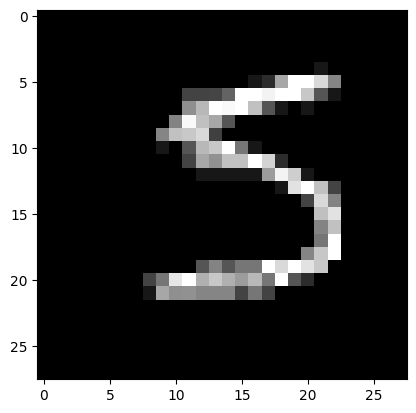

/home/balieiro/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([5])

In [6]:
# Testando número
num = Num('imgs/cinco.png', invert=True)
num.plot()
model.predict(num.to_array())

